# **Electric Power Consumption**

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import time
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings 
warnings.filterwarnings('ignore')

/kaggle/input/electric-power-consumption/powerconsumption.csv


## **Procesamiento de Data**

In [4]:
url='/kaggle/input/electric-power-consumption/powerconsumption.csv'
df=pd.read_csv(url,sep=',')
print(df.shape)

(52416, 9)


In [5]:
df['Datetime']=pd.to_datetime(df['Datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Datetime                52416 non-null  datetime64[ns]
 1   Temperature             52416 non-null  float64       
 2   Humidity                52416 non-null  float64       
 3   WindSpeed               52416 non-null  float64       
 4   GeneralDiffuseFlows     52416 non-null  float64       
 5   DiffuseFlows            52416 non-null  float64       
 6   PowerConsumption_Zone1  52416 non-null  float64       
 7   PowerConsumption_Zone2  52416 non-null  float64       
 8   PowerConsumption_Zone3  52416 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 3.6 MB


In [6]:
num=df.select_dtypes(include='number').columns
num

Index(['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2',
       'PowerConsumption_Zone3'],
      dtype='object')

In [9]:
# Calcular la diferencia entre fechas consecutivas
deltas = df['Datetime'].diff()

# Verificar si todas las diferencias son de 10 minutos
intervalo_esperado = pd.Timedelta(minutes=10)
diferencias_correctas = (deltas[1:] == intervalo_esperado)  # se ignora el primer NaT

# Resultado general
if diferencias_correctas.all():
    print("✅ Todos los intervalos son de 10 minutos.")
else:
    print("❌ Hay diferencias que no son de 10 minutos.")
    print("Filas con error:")
    print(df[~diferencias_correctas.shift(fill_value=True)])

✅ Todos los intervalos son de 10 minutos.


In [10]:
def create_features_time(df):
    df['Mes'] = df['Datetime'].dt.month
    df['Día'] = df['Datetime'].dt.day
    df['Año'] = df['Datetime'].dt.year
    df['Hora'] = df['Datetime'].dt.hour
    df['Minute'] = df['Datetime'].dt.minute
    df['Trimestre']=df['Datetime'].dt.quarter
    df['Temporada'] = df['Mes'] % 12 // 3 + 1
    df['Diadelaño'] = df['Datetime'].dt.dayofyear
    df['Diadelasemana'] = df['Datetime'].dt.dayofweek
    df['weekofyear'] = df['Datetime'].dt.isocalendar().week
    return df


df_new=create_features_time(df)
df_new=df_new.set_index('Datetime')
df_new
    

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Mes,Día,Año,Hora,Minute,Trimestre,Temporada,Diadelaño,Diadelasemana,weekofyear
Datetime,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,1,1,2017,0,0,1,1,1,6,52
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,1,1,2017,0,10,1,1,1,6,52
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,1,1,2017,0,20,1,1,1,6,52
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,1,1,2017,0,30,1,1,1,6,52
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,1,1,2017,0,40,1,1,1,6,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,12,30,2017,23,10,4,1,364,5,52
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,12,30,2017,23,20,4,1,364,5,52
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,12,30,2017,23,30,4,1,364,5,52


## **EDA**

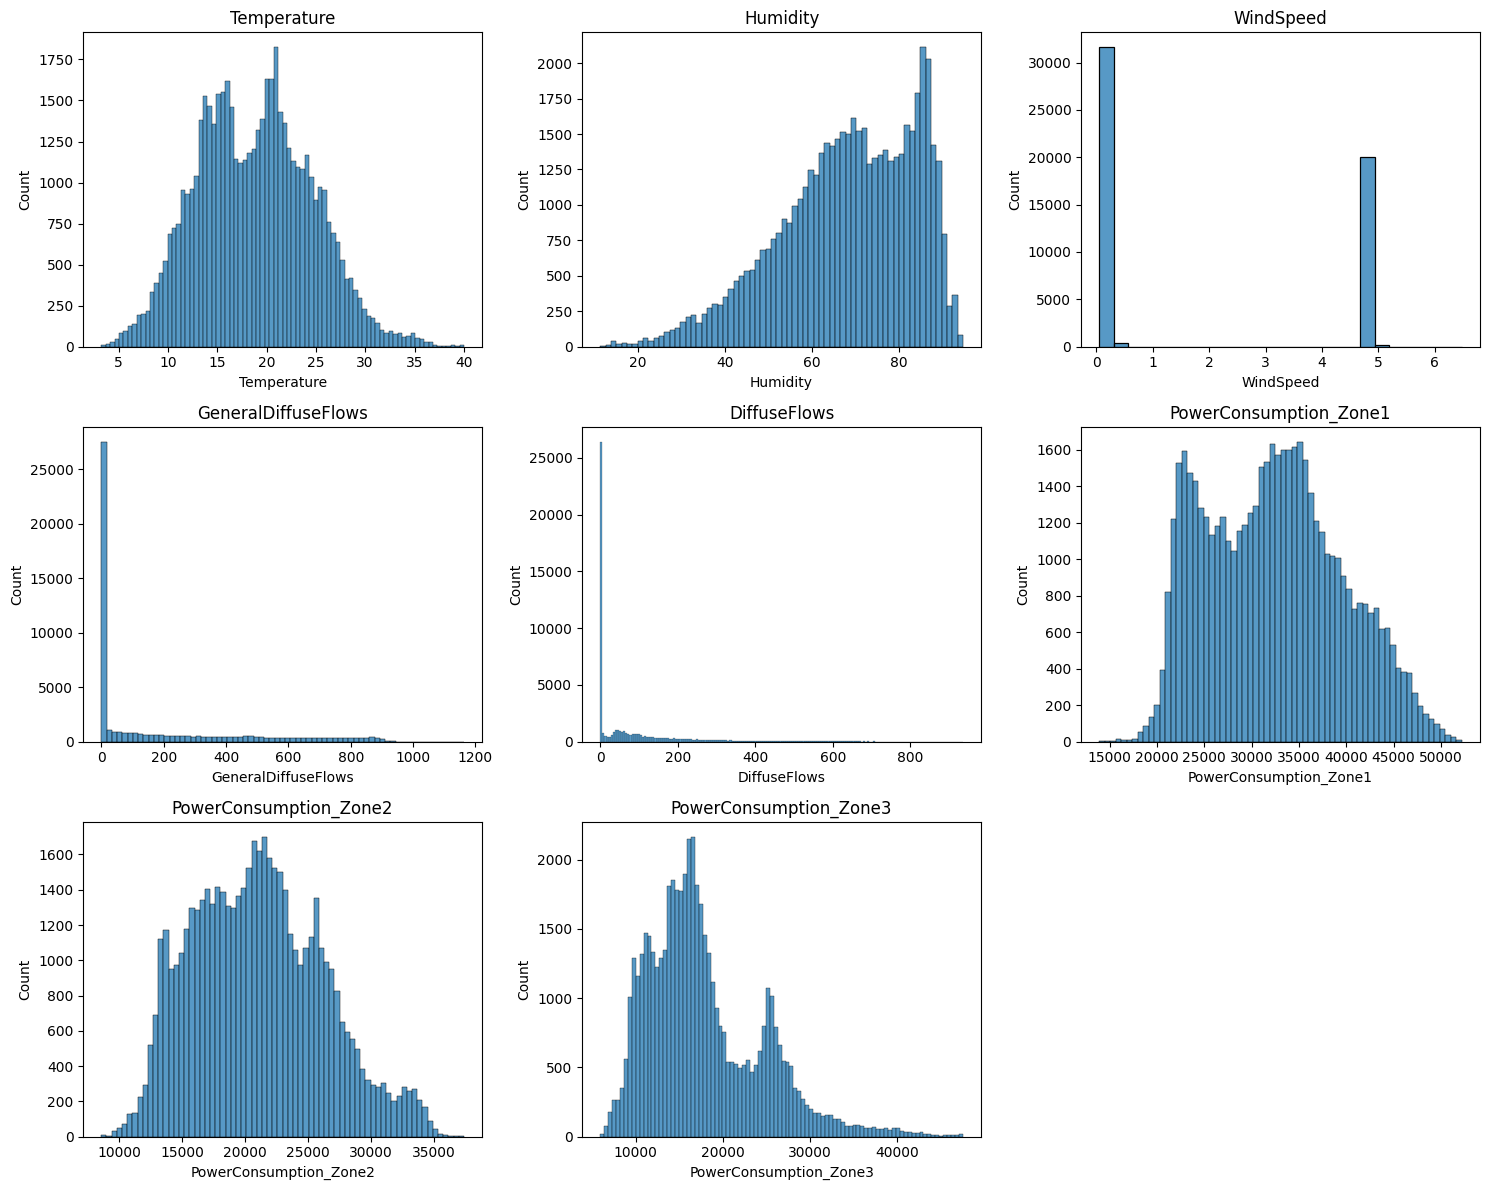

In [49]:
# Crear una figura con 3 filas y 3 columnas
fig, axs = plt.subplots(3, 3, figsize=(15, 12))

# Iterar sobre las columnas numéricas y plotear
for i, col in enumerate(num):
    sns.histplot(data=df, x=col, ax=axs[i // 3, i % 3])
    axs[i // 3, i % 3].set_title(col)

# Eliminar el eje del último subplot vacío
for i in range(len(num), 9):
    axs[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

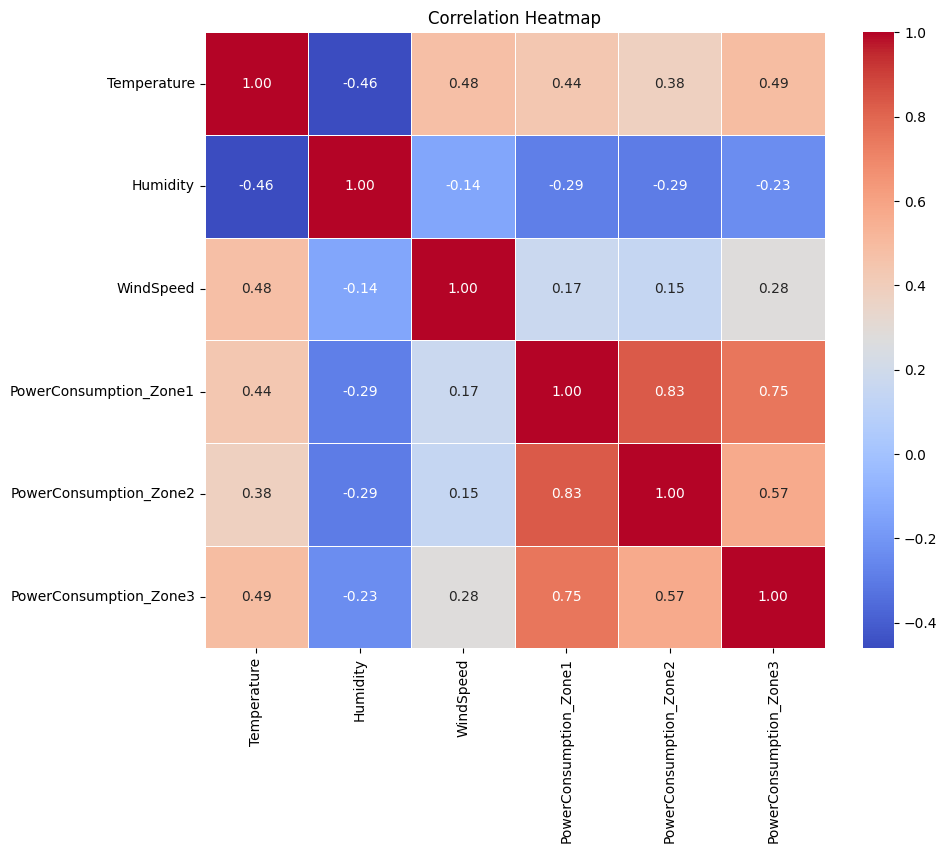

In [11]:
correlation_matrix = df_new[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

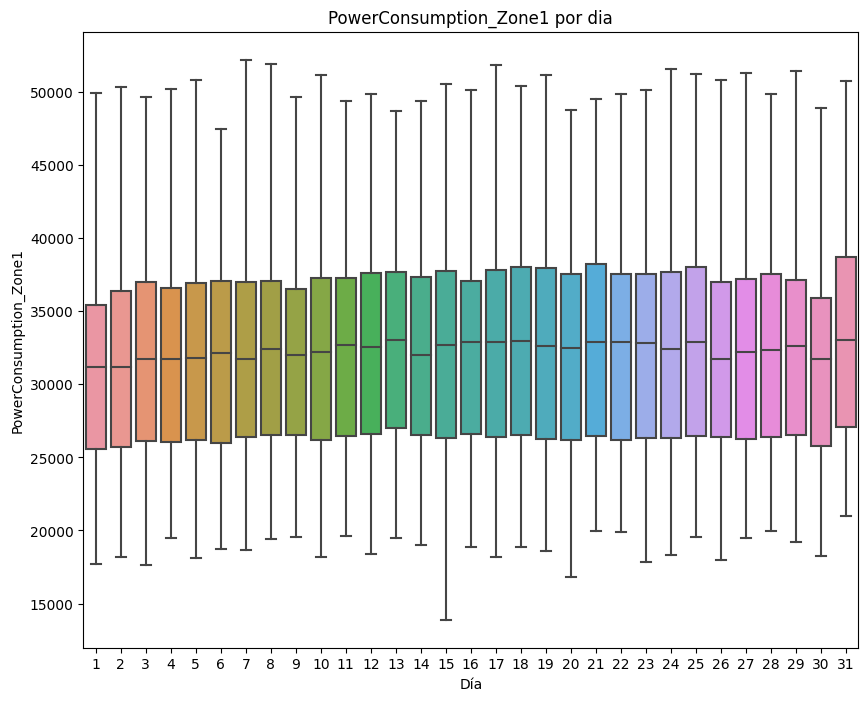

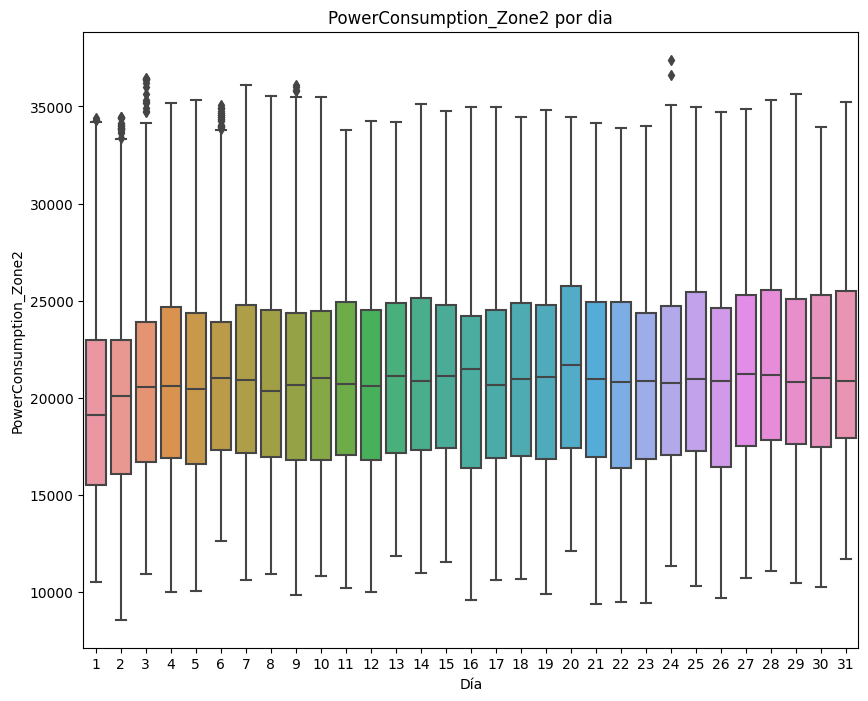

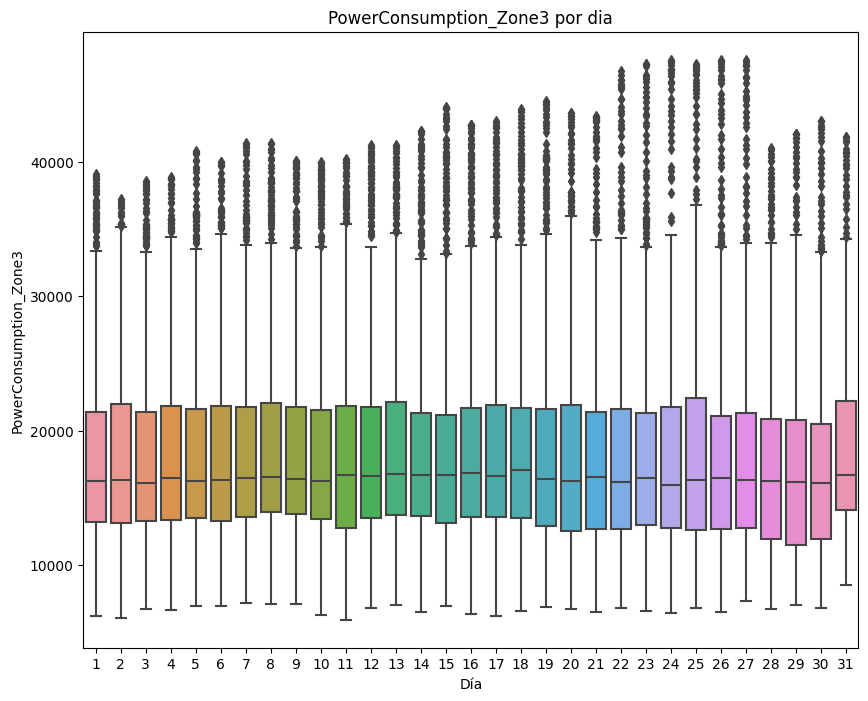

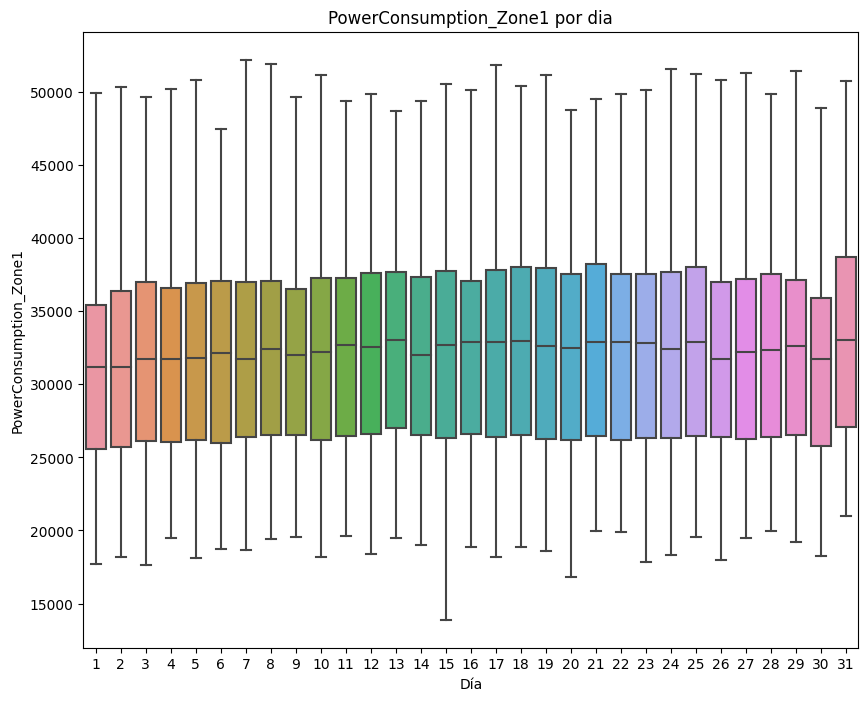

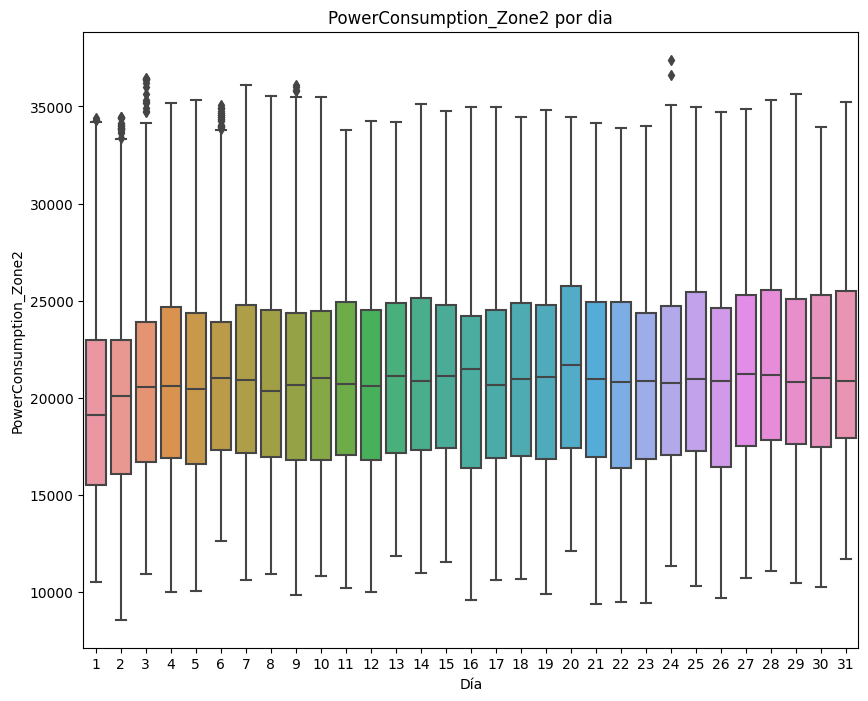

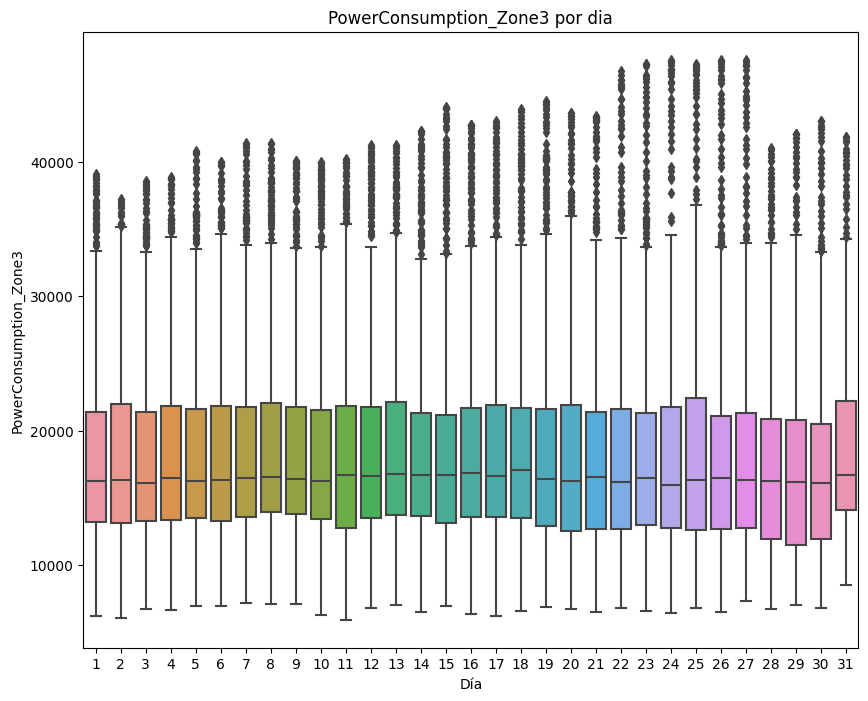

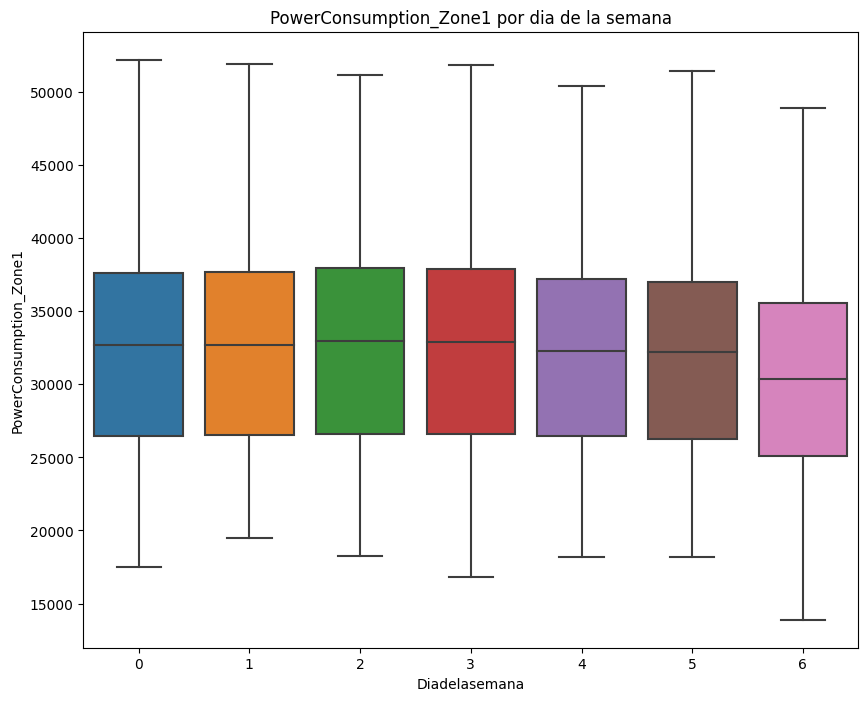

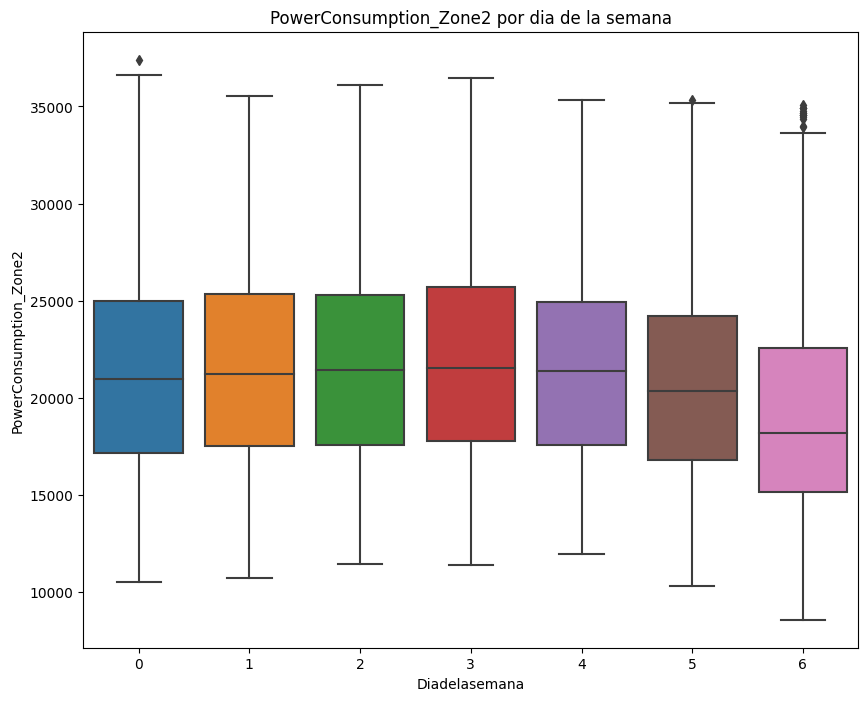

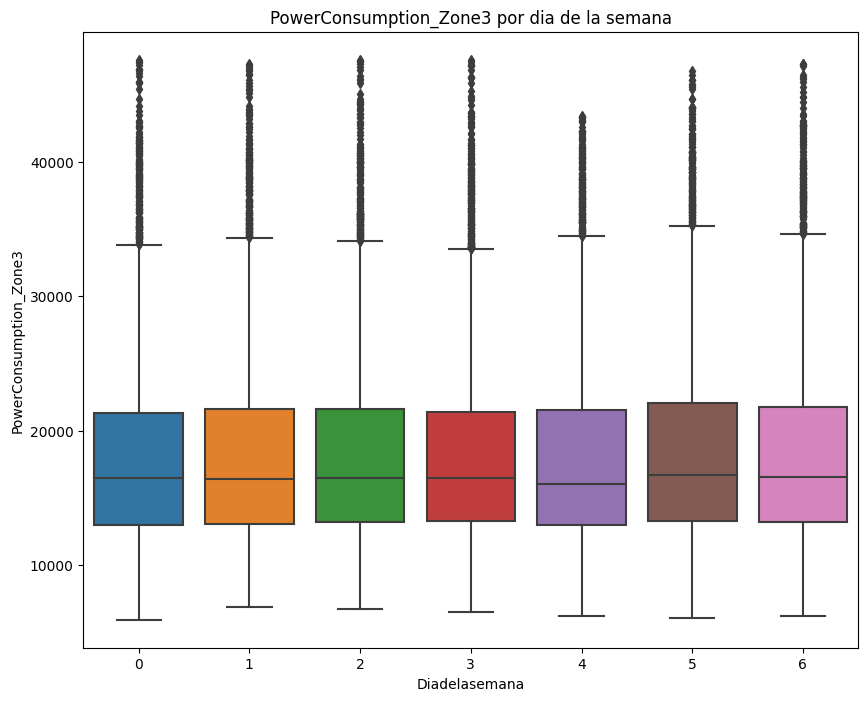

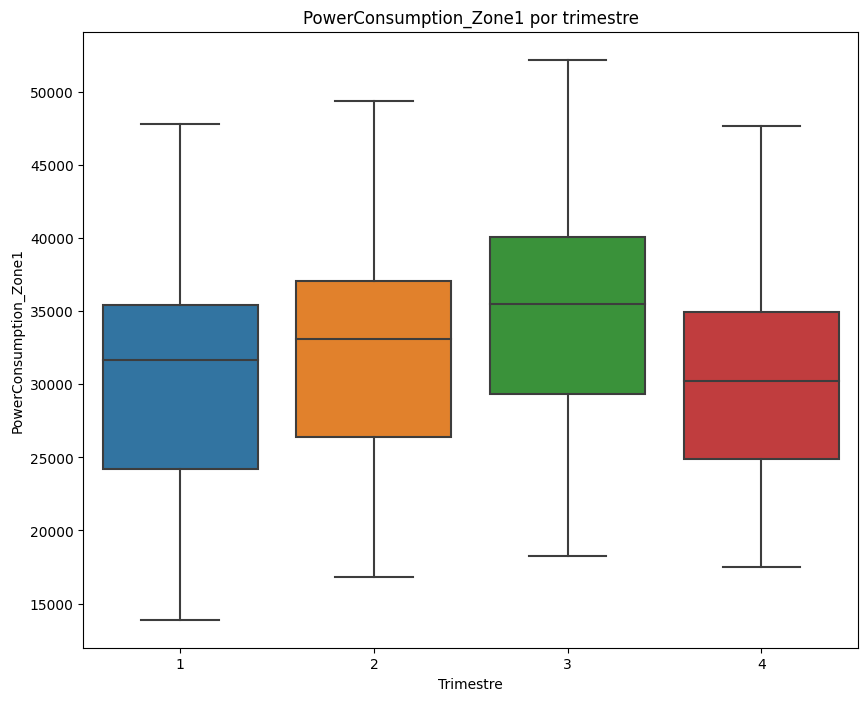

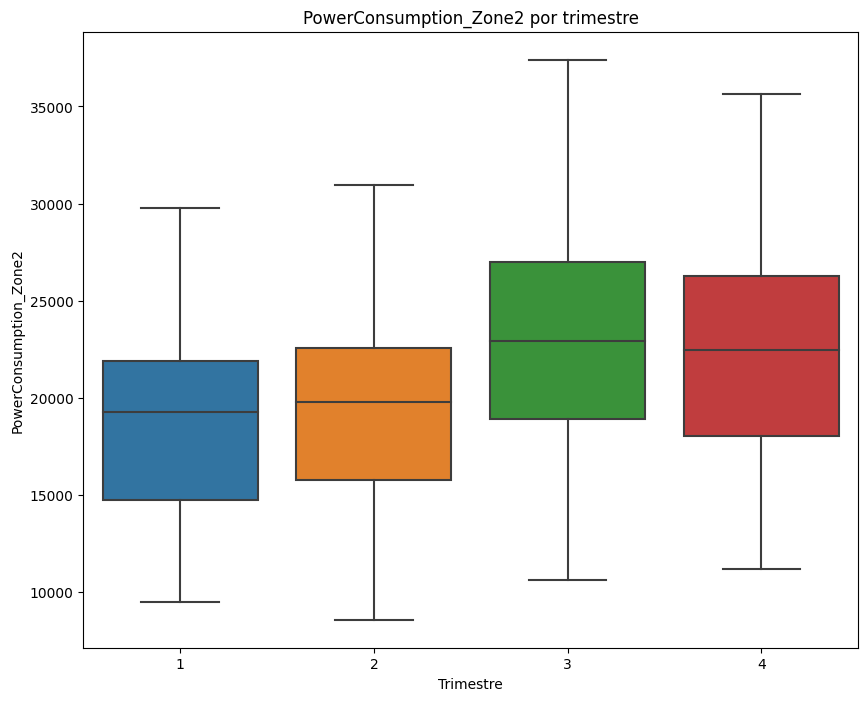

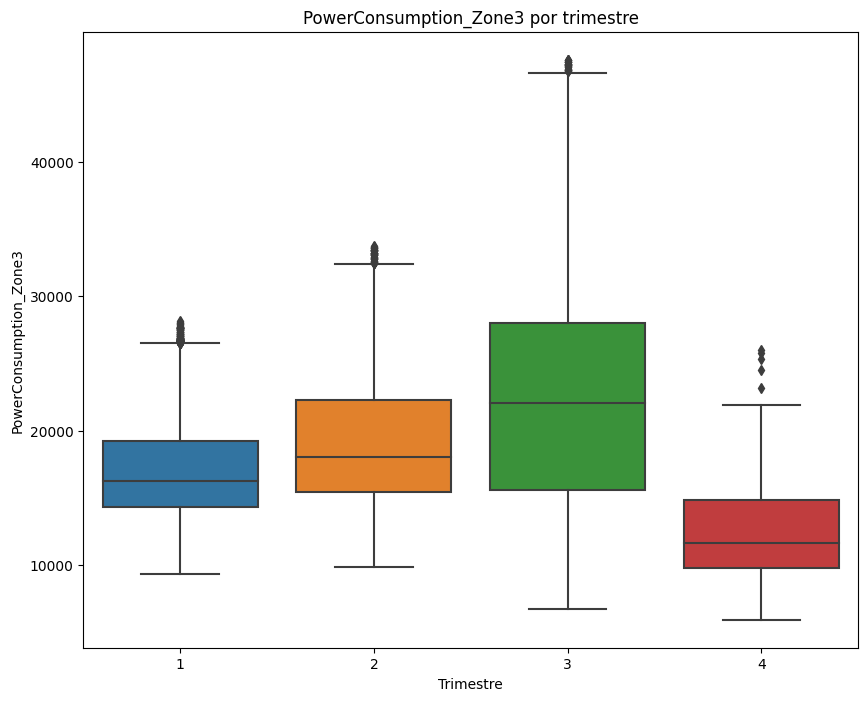

In [12]:
numzone=[ 'PowerConsumption_Zone1', 'PowerConsumption_Zone2',
       'PowerConsumption_Zone3']
for i in numzone:
    plt.figure(figsize=(10,8))
    sns.boxplot(data=df_new,x='Día',y=i)
    plt.title(f"{i} por dia")
    plt.show()
    
for i in numzone:
    plt.figure(figsize=(10,8))
    sns.boxplot(data=df_new,x='Día',y=i)
    plt.title(f"{i} por dia")
    plt.show()

for i in numzone:
    plt.figure(figsize=(10,8))
    sns.boxplot(data=df_new,x='Diadelasemana',y=i)
    plt.title(f"{i} por dia de la semana")
    plt.show()


for i in numzone:
    plt.figure(figsize=(10,8))
    sns.boxplot(data=df_new,x='Trimestre',y=i)
    plt.title(f"{i} por trimestre")
    plt.show()

## **MODELAMIENTO DE LA DATA**

In [13]:
from sklearn.preprocessing import StandardScaler

# Separate the input features (X) and target variables (y)
X = df_new.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1)
y = df_new[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']]

# Initialize StandardScaler for y
scaler_y = StandardScaler()

# Fit and transform  y
y_scaled = scaler_y.fit_transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.25, shuffle=False)

## **MODEL XGBOOSTREGRESOR**

In [20]:
# Hiperparámetros para búsqueda aleatoria
param_dist = {
    'objective': ['reg:squarederror'],
    'max_depth': [2, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7],
    'n_estimators': [1000, 1500, 2000],
    'min_child_weight': [1, 2],
    'booster': ['gbtree'],
    'gamma': [0, 0.1, 0.5],
    'colsample_bytree': [0.7, 0.9],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Modelo base
xgb_model = xgb.XGBRegressor(tree_method='hist', random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones aleatorias que probará
    cv=7,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Entrenar la búsqueda aleatoria
random_search.fit(X_train, y_train)

# Evaluación
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 7 folds for each of 50 candidates, totalling 350 fits


NameError: name 'mean_absolute_error' is not defined

In [25]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("🎯 Mejores hiperparámetros:", random_search.best_params_)
print("📉 Mejor puntuación (MSE negativo):", random_search.best_score_)
print("✅ MSE en test:", mse)
print("✅ MAE en test:", mae)

🎯 Mejores hiperparámetros: {'subsample': 0.5, 'reg_lambda': 2, 'reg_alpha': 1, 'objective': 'reg:squarederror', 'n_estimators': 2000, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7, 'booster': 'gbtree'}
📉 Mejor puntuación (MSE negativo): -0.21904164092415618
✅ MSE en test: 0.26948465148854345
✅ MAE en test: 0.41965923440067926


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

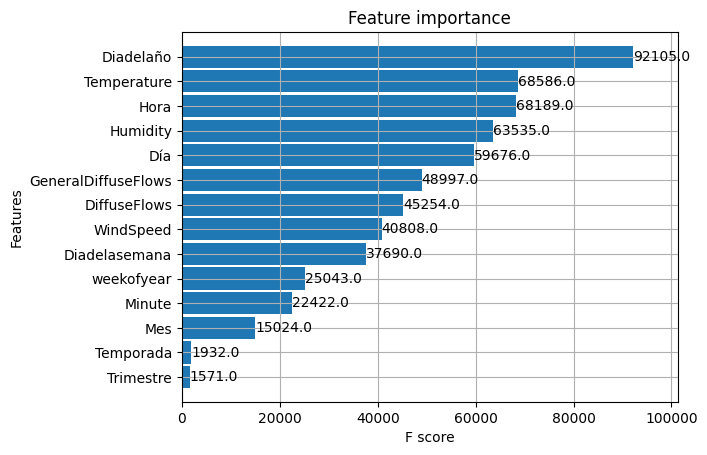

In [27]:
plot_importance(best_model, height=0.9)

In [28]:
# Fit and transform  y
y_test_real = scaler_y.inverse_transform(y_test)
y_pred_real=  scaler_y.inverse_transform(y_pred)

In [41]:
df_resultado = pd.DataFrame(y_test_real, columns=['Meta_Alta', 'Meta_Media', 'Meta_Baja'])
df_prediccion = pd.DataFrame(y_pred_real,columns=['Pred_Meta_Alta', 'Pred_Meta_Media', 'Pred_Meta_Baja'])
df_comparacion = pd.concat([df_resultado, df_prediccion], axis=1)
df_comparacion_new = pd.concat([X_test.reset_index(drop=True), df_comparacion.reset_index(drop=True)], axis=1)
df_comparacion_new

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,Mes,Día,Año,Hora,Minute,...,Temporada,Diadelaño,Diadelasemana,weekofyear,Meta_Alta,Meta_Media,Meta_Baja,Pred_Meta_Alta,Pred_Meta_Media,Pred_Meta_Baja
0,18.120,87.6,4.916,0.080,0.163,10,1,2017,0,0,...,4,274,6,39,31755.62363,17985.06224,14898.96657,31441.771484,18316.056641,14826.970703
1,18.000,88.5,4.916,0.055,0.137,10,1,2017,0,10,...,4,274,6,39,31175.84245,17611.61826,14531.30699,31302.513672,18367.759766,15044.180664
2,18.010,88.4,4.916,0.069,0.148,10,1,2017,0,20,...,4,274,6,39,30154.92341,17148.54772,14321.21581,30691.042969,18100.160156,14799.515625
3,18.160,88.4,4.914,0.062,0.167,10,1,2017,0,30,...,4,274,6,39,29764.20131,16827.38589,14198.66261,30317.671875,17895.000000,14742.738281
4,18.180,89.1,4.917,0.051,0.115,10,1,2017,0,40,...,4,274,6,39,29600.35011,16621.99170,13889.36170,30102.558594,17585.914062,14852.833008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13099,7.010,72.4,0.080,0.040,0.096,12,30,2017,23,10,...,1,364,5,52,31160.45627,26857.31820,14780.31212,32629.261719,20182.710938,17331.994141
13100,6.947,72.6,0.082,0.051,0.093,12,30,2017,23,20,...,1,364,5,52,30430.41825,26124.57809,14428.81152,32036.066406,19702.361328,17015.300781
13101,6.900,72.8,0.086,0.084,0.074,12,30,2017,23,30,...,1,364,5,52,29590.87452,25277.69254,13806.48259,31331.537109,19247.753906,16992.255859
13102,6.758,73.0,0.080,0.066,0.089,12,30,2017,23,40,...,1,364,5,52,28958.17490,24692.23688,13512.60504,30739.863281,18882.683594,16820.550781


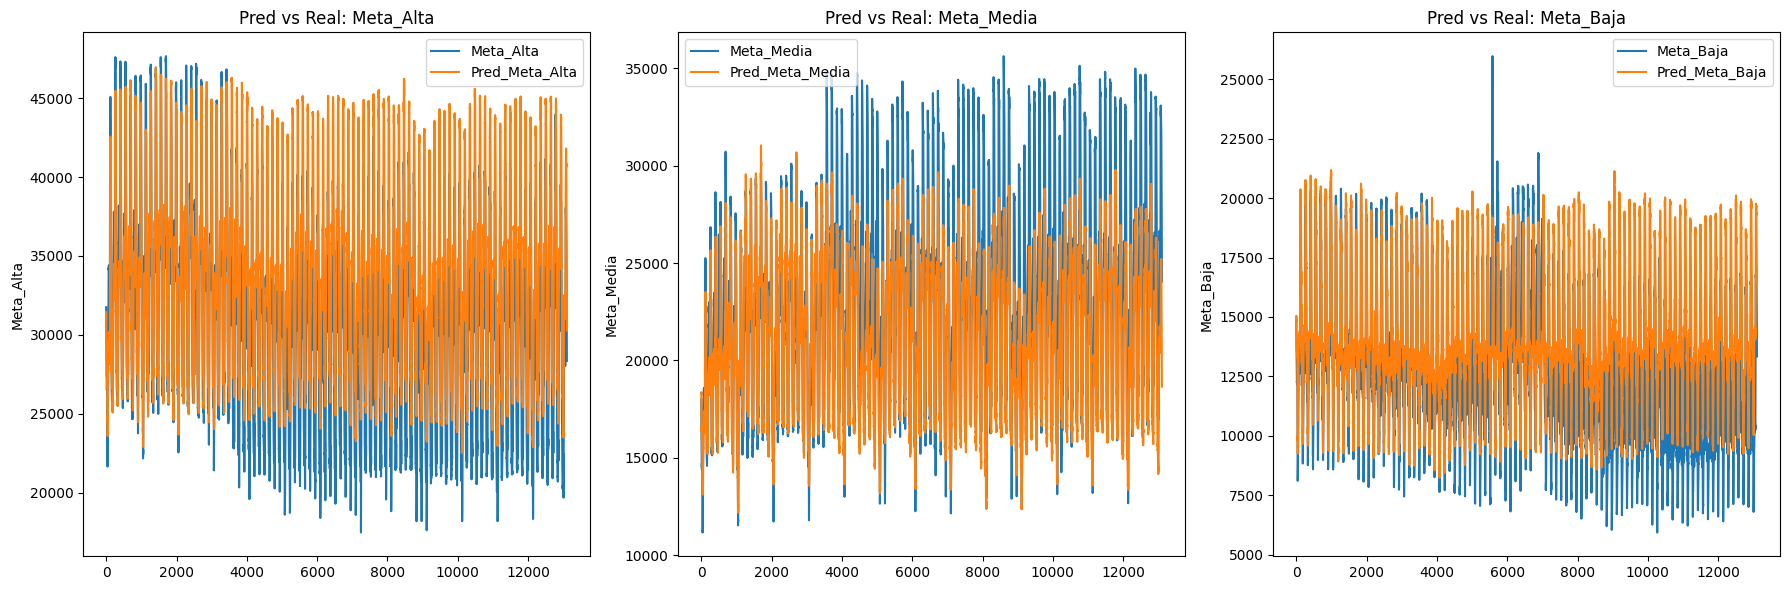

In [51]:
# Crear figura y ejes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Meta_Alta
sns.lineplot(data=df_comparacion_new, x=df_comparacion_new.index, y='Meta_Alta', label='Meta_Alta', ax=axes[0])
sns.lineplot(data=df_comparacion_new, x=df_comparacion_new.index, y='Pred_Meta_Alta', label='Pred_Meta_Alta', ax=axes[0])
axes[0].set_title('Pred vs Real: Meta_Alta')
axes[0].legend()

# Meta_Media
sns.lineplot(data=df_comparacion_new, x=df_comparacion_new.index, y='Meta_Media', label='Meta_Media', ax=axes[1])
sns.lineplot(data=df_comparacion_new, x=df_comparacion_new.index, y='Pred_Meta_Media', label='Pred_Meta_Media', ax=axes[1])
axes[1].set_title('Pred vs Real: Meta_Media')
axes[1].legend()

# Meta_Baja
sns.lineplot(data=df_comparacion_new, x=df_comparacion_new.index, y='Meta_Baja', label='Meta_Baja', ax=axes[2])
sns.lineplot(data=df_comparacion_new, x=df_comparacion_new.index, y='Pred_Meta_Baja', label='Pred_Meta_Baja', ax=axes[2])
axes[2].set_title('Pred vs Real: Meta_Baja')
axes[2].legend()

# Ajustar layout
plt.tight_layout()
plt.show()